# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import os
import pandas as pd
from types import SimpleNamespace

from td3_agent import AgentTD3
from ddpg_agent import AgentDDPG

from unityagents import UnityEnvironment

Check if cuda enabled gpu is available

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Select of the Unit Environment for the Continuous Control project

In [4]:
#env = UnityEnvironment(file_name='Reacher_Linux_One/Reacher.x86_64')
env = UnityEnvironment(file_name='Reacher_Linux_20/Reacher.x86_64')
#env = UnityEnvironment(file_name='Crawler_Linux/Crawler.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space
states = env_info.vector_observations
state_size = states.shape[1]

print('There are {} agents. Each observes a state with length: {}'.format(
    states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [6]:
def actor_critic_train(env, agent, cfg, brain_name, num_agents,
                       print_every=1):
    """Actor Critic based Training

    Params
    ======
        env                   : Environment
        agent                 : Instance of Agent
        cfg                   : Configuration of training 
        brain_name            : Name of brain
        num_agents            : Number of Agents
        print_every (int)     : interval to display results

    """
    n_episodes = int(cfg['N_EPISODES'])
    max_t = int(cfg['MAX_T'])
    save_n_episodes = int(cfg['SAVE_N_EPISODES'])

    # list of mean scores from each episode
    mean_scores = []
    # list of lowest scores from each episode
    min_scores = []
    # list of highest scores from each episode
    max_scores = []
    # mean scores from most recent episodes
    df = pd.DataFrame(columns=['episode', 'duration',
                               'min', 'max', 'std', 'mean'])

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset environment
        # get current state for each agent
        states = env_info.vector_observations
        # initialize score for each agent
        scores = np.zeros(num_agents)
        agent.reset()
        start_time = time.time()
        for t in range(max_t):

            # select an action
            actions = agent.act(states, add_noise=True)
            # send actions to environment
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations    # get next state
            rewards = env_info.rewards                    # get reward
            # see if episode has finished
            dones = env_info.local_done

            # save experience to replay buffer, perform learning step at
            # defined interval
            for state, action, reward, next_state, done in zip(states, actions,
                                                               rewards,
                                                               next_states,
                                                               dones):
                agent.step(state, action, reward, next_state, done, t)

            states = next_states

            scores += rewards
            if np.any(dones):  # exit loop when episode ends
                break
        # save time needed for episode
        duration = time.time() - start_time
        # save lowest score for a single agent
        min_scores.append(np.min(scores))
        # save highest score for a single agent
        max_scores.append(np.max(scores))
        # save mean score for the episode
        mean_scores.append(np.mean(scores))

        df.loc[i_episode-1] = [i_episode] + list([round(duration),
                                                  np.min(scores),
                                                  np.max(scores),
                                                  np.std(scores),
                                                  np.mean(scores)])

        if i_episode % print_every == 0:
            print('\rEpisode {} ({} sec)  -- \tMin: {:.1f}\tMax: {:.1f}\tMean: {:.1f}'.format(
                  i_episode, round(duration), min_scores[-1], max_scores[-1],
                  mean_scores[-1]))

        if i_episode % save_n_episodes == 0:
            epi_str = "{:03}".format(i_episode)
            torch.save(agent.actor_local.state_dict(),
                       agent.name+"_"+epi_str+"_actor_ckpt.pth")
            torch.save(agent.critic_local.state_dict(),
                       agent.name+"_"+epi_str+"_critic_ckpt.pth")
    
    torch.save(agent.actor_local.state_dict(),
               agent.name+"_final_actor_ckpt.pth")
    torch.save(agent.critic_local.state_dict(),
               agent.name+"_final_critic_ckpt.pth")

    return df

In [7]:
def actor_critic_test(env, agent, cfg, ckpt, n_episodes=100):
    """Actor Critic based Testing

    Params
    ======
        env                   : Environment
        agent                 : Instance of Agent
        cfg                   : Configuration of training 
        ckpt                  : Number of checkpoint used for testing
        n_episodes (int)      : Number of episodes for testing

    """    
    df = pd.DataFrame(columns=['episode', 'duration',
                               'min', 'max', 'std', 'mean'])

    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]

    # number of agents
    num_agents = len(env_info.agents)
    print('Number of agents:', num_agents)

    # size of each action
    action_size = brain.vector_action_space_size
    print('Size of each action:', action_size)

    # examine the state space
    states = env_info.vector_observations
    state_size = states.shape[1]

    print('There are {} agents. Each observes a state with length: {}'.format(
        states.shape[0], state_size))
    print('The state for the first agent looks like:', states[0])

    ckpt_path = cfg['CKPT_PATH']
    actor_path = '{}/{}_{}_actor_ckpt.pth'.format(ckpt_path, agent.name, ckpt)
    critic_path = '{}/{}_{}_critic_ckpt.pth'.format(ckpt_path, agent.name, ckpt)
    if not os.path.exists(actor_path) or not os.path.exists(critic_path):
        print("Checkpoint(s) not found: {},{}".format(actor_path, critic_path))
        return df

    if torch.cuda.is_available():
        agent.actor_local.load_state_dict(torch.load(actor_path))
        agent.critic_local.load_state_dict(
            torch.load(critic_path))
    else:
        agent.actor_local.load_state_dict(torch.load(
            actor_path, map_location=lambda storage, loc: storage))
        agent.critic_local.load_state_dict(torch.load(
            critic_path, map_location=lambda storage, loc: storage))

    for i_episode in range(0, n_episodes):
        env_info = env.reset(train_mode=True)[
            brain_name]     # reset the environment
        # get the current state (for each agent)
        states = env_info.vector_observations
        # initialize the score (for each agent)
        scores = np.zeros(num_agents)
        start_time = time.time()
        while True:
            # select an action
            actions = agent.act(states, add_noise=False)
            # send all actions to tne environment
            env_info = env.step(actions)[brain_name]
            # get next state (for each agent)
            next_states = env_info.vector_observations
            # get reward (for each agent)
            rewards = env_info.rewards
            dones = env_info.local_done  # see if episode finished
            # update the score (for each agent)
            scores += rewards
            # roll over states to next time step
            states = next_states
            if np.any(dones):  # exit loop if episode finished
                break
        duration = time.time() - start_time
        
        df.loc[i_episode] = [i_episode+1] + list([round(duration),
                                                  np.min(scores),
                                                  np.max(scores),
                                                  np.std(scores),
                                                  np.mean(scores)])

        print('\rEpisode {} ({} sec)\tMean: {:.1f}'.format(
            i_episode, round(duration), np.mean(scores)))

    return df

In [8]:
def plot_train(df):
    """Print min max plot of DQN Agent analytics

    Params
    ======
        df :    Dataframe with scores
    """
    ax = df.plot(x='episode', y='mean')
    plt.fill_between(x='episode', y1='min', y2='max',
                     color='lightgrey', data=df)
    x_coordinates = [0, 150]
    y_coordinates = [30, 30]
    plt.plot(x_coordinates, y_coordinates, color='red')
    plt.show()

In [9]:
#agent = AgentDDPG(state_size=state_size, action_size=action_size,
#                  random_seed=1, cfg_path="config.ini")

In [10]:
agent = AgentTD3(state_size=state_size, action_size=action_size,
                  random_seed=1, cfg_path="config.ini")

In [11]:
df = actor_critic_train(env, agent, agent.cfg, brain_name, num_agents)

Episode 1 (68 sec)  -- 	Min: 0.1	Max: 2.1	Mean: 1.0
Episode 2 (70 sec)  -- 	Min: 0.2	Max: 3.4	Mean: 1.4
Episode 3 (70 sec)  -- 	Min: 0.5	Max: 2.5	Mean: 1.6
Episode 4 (72 sec)  -- 	Min: 0.2	Max: 3.8	Mean: 1.9
Episode 5 (72 sec)  -- 	Min: 0.2	Max: 4.9	Mean: 2.0
Episode 6 (72 sec)  -- 	Min: 1.0	Max: 3.0	Mean: 1.8
Episode 7 (73 sec)  -- 	Min: 0.2	Max: 3.7	Mean: 2.2
Episode 8 (73 sec)  -- 	Min: 0.8	Max: 5.2	Mean: 2.6
Episode 9 (74 sec)  -- 	Min: 1.7	Max: 5.0	Mean: 2.9
Episode 10 (73 sec)  -- 	Min: 0.9	Max: 5.7	Mean: 3.3
Episode 11 (75 sec)  -- 	Min: 1.4	Max: 7.8	Mean: 3.9
Episode 12 (75 sec)  -- 	Min: 0.6	Max: 7.1	Mean: 4.4
Episode 13 (75 sec)  -- 	Min: 1.1	Max: 8.5	Mean: 5.6
Episode 14 (74 sec)  -- 	Min: 5.6	Max: 17.0	Mean: 7.8
Episode 15 (75 sec)  -- 	Min: 4.5	Max: 14.8	Mean: 8.7
Episode 16 (75 sec)  -- 	Min: 5.3	Max: 13.3	Mean: 9.3
Episode 17 (76 sec)  -- 	Min: 6.3	Max: 20.0	Mean: 10.5
Episode 18 (78 sec)  -- 	Min: 6.7	Max: 15.5	Mean: 11.6
Episode 19 (78 sec)  -- 	Min: 9.1	Max: 17.2	Mean

Episode 146 (109 sec)  -- 	Min: 32.7	Max: 39.6	Mean: 37.6
Episode 147 (109 sec)  -- 	Min: 21.6	Max: 39.6	Mean: 33.2
Episode 148 (111 sec)  -- 	Min: 18.7	Max: 38.8	Mean: 31.9
Episode 149 (109 sec)  -- 	Min: 23.1	Max: 39.4	Mean: 31.4
Episode 150 (109 sec)  -- 	Min: 22.5	Max: 39.7	Mean: 34.0


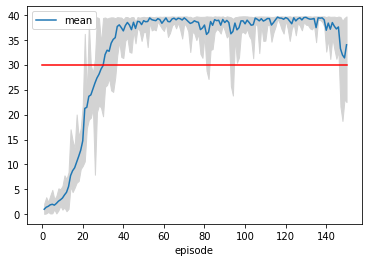

In [13]:
plot_train(df)